Installing & Importing required libraries

In [1]:
!pip install -U 'skillsnetwork' 'nbformat'
!pip install dtreeviz
!pip install scikit-learn==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for o

In [2]:
from ast import increment_lineno
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")

import numpy as np
import skillsnetwork
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

Detecting Cyber Attacks

In [3]:
def check_security_rules(network_packet):
    if network_packet["sttl"]>10:
      print("ALARM: Suspicious TTL value")
    if network_packet["dttl"]>15:
      print("ALARM: Suspicious D-TTL value")
    if network_packet["rate"]>1000:
      print("ALARM: Suspicious rate value")
    if network_packet["Dload"]>500:
      print("ALARM: Suspicious Dload value")
    if network_packet["Sload"]>500:
      print("ALARM: Suspicious Sload value")

network_packet = {
    "sttl":9,
    "dttl":14,
    "rate":900,
    "Dload":400,
    "Sload":400,
}
check_security_rules(network_packet)


Dataset

In [4]:
training = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_training-set.csv")
testing = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0Q8REN/UNSW_NB15_testing-set.csv")
print("training ",training.shape)
print("testing ",testing.shape)

training  (82332, 45)
testing  (175341, 45)


In [5]:
all(training.columns == testing.columns)

True

In [6]:
df = pd.concat([training,testing]).drop('id',axis=1)
df = df.reset_index(drop=True)

# print one attack sample
df.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0


In [7]:
df.attack_cat.unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

Data Exploration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

In [9]:
for col in ['proto', 'service', 'state']:
    df[col] = df[col].astype('category').cat.codes
    df[col] = df[col].astype('category').cat.codes

df['attack_cat'] = df['attack_cat'].astype('category')

attack_cat
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Normal                0
Name: count, dtype: int64


<Axes: ylabel='count'>

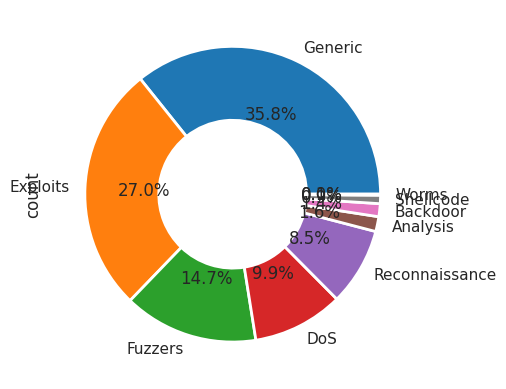

In [10]:
print(df[df['label']==1]
     ['attack_cat']
     .value_counts()
)
# plot the pie plot of attacks
df[df['label']==1]['attack_cat'].value_counts()\
    .plot\
    .pie(autopct='%1.1f%%',wedgeprops={'linewidth': 2, 'edgecolor': 'white', 'width': 0.50})

Postives and Negatives

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X=df.loc [:, ~df.columns.isin(['attack_cat', 'label'])]
y=df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)
feature_names = list(X.columns)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (180371, 42)
y_train shape:  (180371,)
X_test shape:  (77302, 42)
y_test shape:  (77302,)


Use of Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 1.0


In [14]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

clf=grid_search.best_estimator_

y_pred = clf.predict(X_test)

recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

Recall:  1.0


|--- sttl <= 61.00
|   |--- sinpkt <= 0.00
|   |   |--- class: 1
|   |--- sinpkt >  0.00
|   |   |--- class: 0
|--- sttl >  61.00
|   |--- synack <= 0.04
|   |   |--- class: 1
|   |--- synack >  0.04
|   |   |--- class: 1



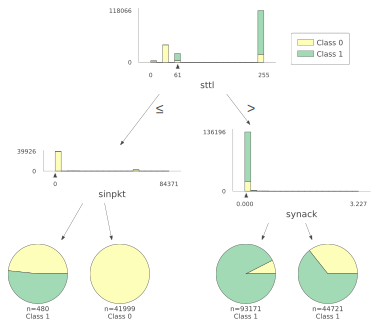

In [20]:
from sklearn.tree import export_text
import dtreeviz
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
print(export_text(clf,feature_names=feature_names))

viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train,
                           feature_names=feature_names)

v = viz_model.view(fancy=True)
v

In [22]:
X_test = X_test.reset_index(drop=True)

rules= "(sttl <= 61.00 & sinpkt<= 0.00) | (sttl >  61.00 )"

ind = X_test.query(rules).index

X_test_2 = X_test.loc[ind,:]
y_test_2 = y_test[ind]

print(X_test.shape)
print(X_test_2.shape)
print("filtered data" , (1- np.round(X_test_2.shape[0] / X_test.shape[0],2))*100, "%")

(77302, 42)
(59425, 42)
filtered data 23.0 %


Building Machine Learning model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

rf = RandomForestClassifier(random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test_2)

acc = accuracy_score(y_test_2, y_pred)
rec = recall_score(y_test_2, y_pred)
per = precision_score(y_test_2, y_pred)
print("Recall: ", rec)
print("Percision: ", per)
print("Accuracy: ", acc)

Recall:  0.9574644358228257
Percision:  0.964559074993893
Accuracy:  0.9352797644089188


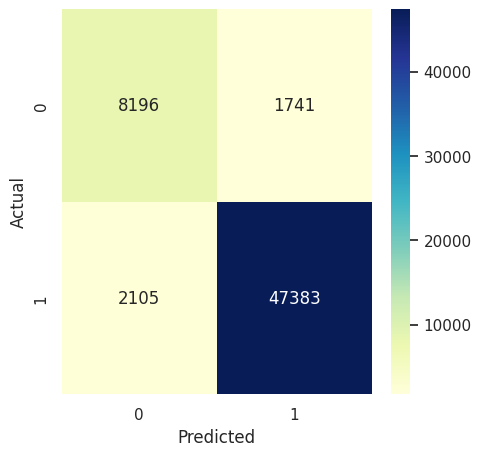

In [24]:
cross = pd.crosstab(pd.Series(y_test_2, name='Actual'), pd.Series(y_pred, name='Predicted'))
plt.figure(figsize=(5, 5))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")
plt.show()

In [25]:
from sklearn.tree import export_text
feature_names = list(X.columns)

with open("Tree_output.txt", "w") as file:
    print(export_text(rf.estimators_[99],
            spacing=3, decimals=2,
            feature_names=feature_names), file=file)

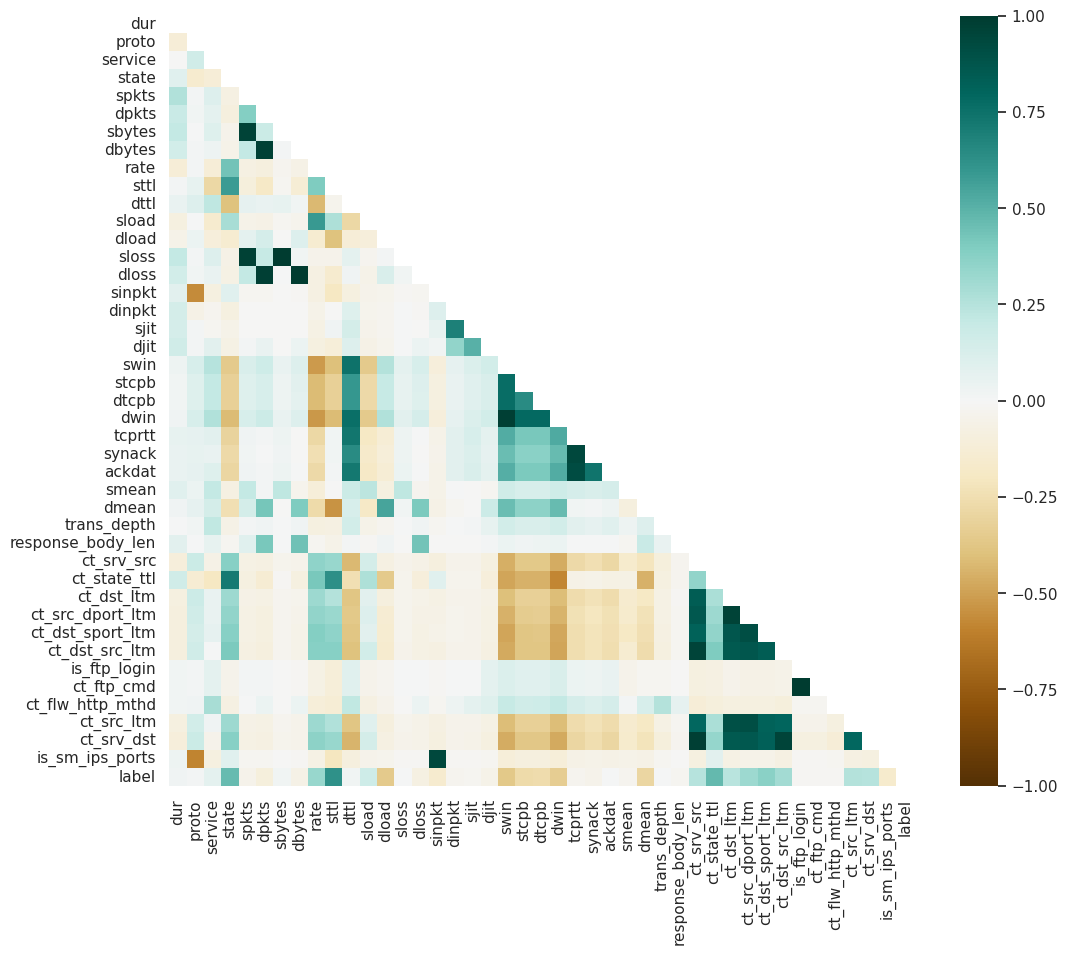

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = df.select_dtypes(include=[np.number])

corr_matrix = numerical_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='BrBG', mask=mask)

plt.show()


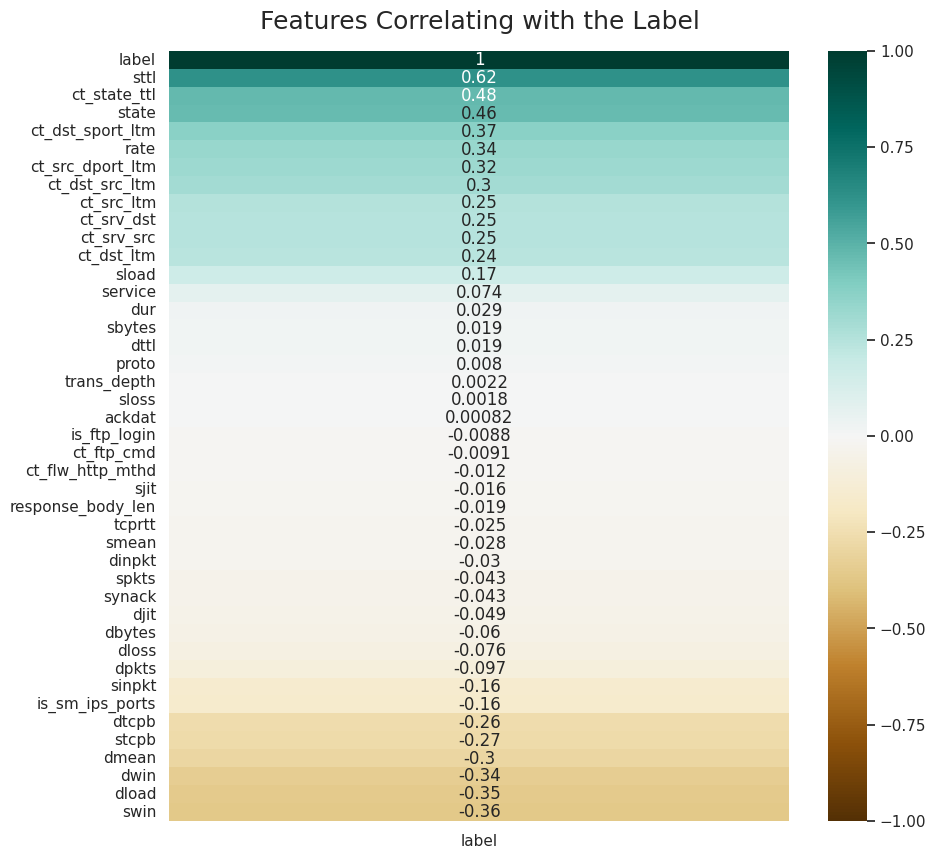

In [36]:
if df['label'].dtype == 'object':
    label_series = df['label']
    numerical_df = df.select_dtypes(include=[np.number])
    numerical_df['label'] = label_series.astype('category').cat.codes
else:
    numerical_df = df.select_dtypes(include=[np.number])

corr_matrix = numerical_df.corr()

sorted_corr = corr_matrix[['label']].sort_values(by='label', ascending=False)

plt.figure(figsize=(10, 10))

heatmap = sns.heatmap(sorted_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with the Label', fontdict={'fontsize':18}, pad=16)

plt.show()

Feature Ranking system

In [38]:
feature_imp = pd.DataFrame({'Name':X.columns, 'Importance':rf.feature_importances_})

feature_imp = feature_imp.sort_values('Importance',ascending=False).reset_index(drop=True)

feature_imp[:10].style.background_gradient()

,Name,Importance
0,sttl,0.139708
1,ct_state_ttl,0.107578
2,rate,0.052387
3,dload,0.049926
4,sload,0.047473
5,sbytes,0.040504
6,ct_dst_src_ltm,0.040064
7,smean,0.039948
8,ct_srv_dst,0.036520
9,dbytes,0.034286


<Axes: >

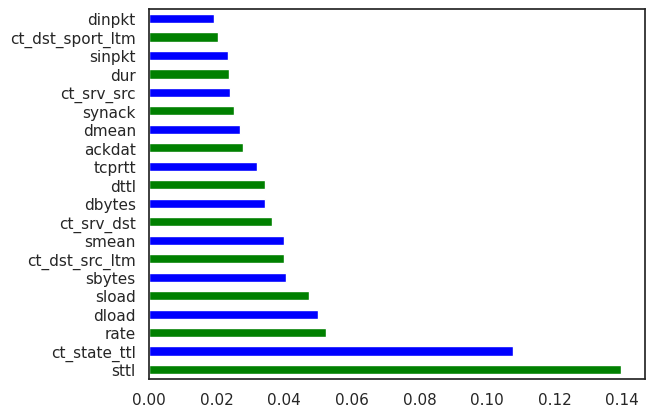

In [39]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',color=['g','b']*5)

Comparing the performance of 10 features

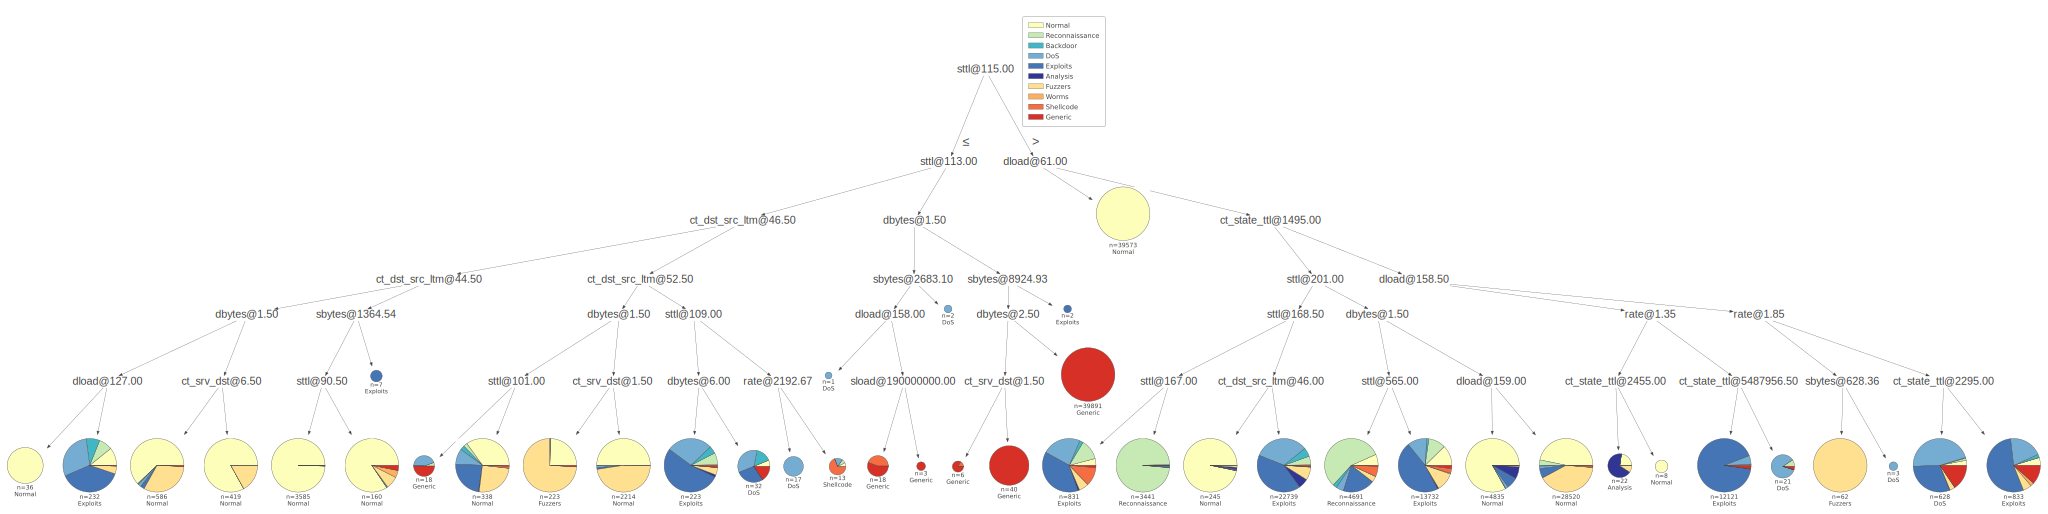

In [40]:
top10= feature_imp.Name[:10].tolist()

attack_names = np.array(df['attack_cat'].unique())

X_top = df.loc[:, df.columns.isin(top10)]
y_top = pd.factorize(df['attack_cat'])[0]

clf_top10 = DecisionTreeClassifier(max_depth=6)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y_top, test_size=0.3, random_state=11)

clf_top10.fit(X_train_top, y_train_top)

viz_model = dtreeviz.model(clf_top10,
                           X_train=X_train_top, y_train=y_train_top,
                           class_names=attack_names,
                           feature_names=top10)

v = viz_model.view(fancy=False,scale=1)
v

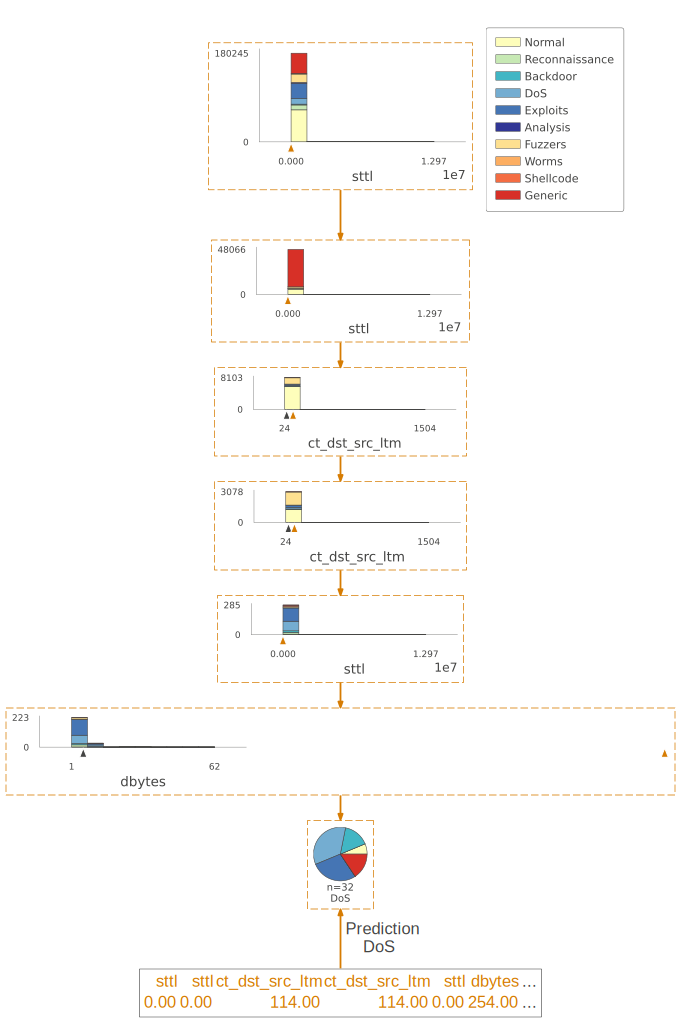

In [41]:
rand = np.random.randint(0, len(X))
sample_point = X.iloc[rand,:].values

v = viz_model.view(fancy=True,scale=1.5,x=sample_point,show_just_path=True)
v

We ran random forest with attack category as the prediction labels and plot the confusion matrix

Accuracy:  0.8246875889368969


<Axes: xlabel='col_0', ylabel='row_0'>

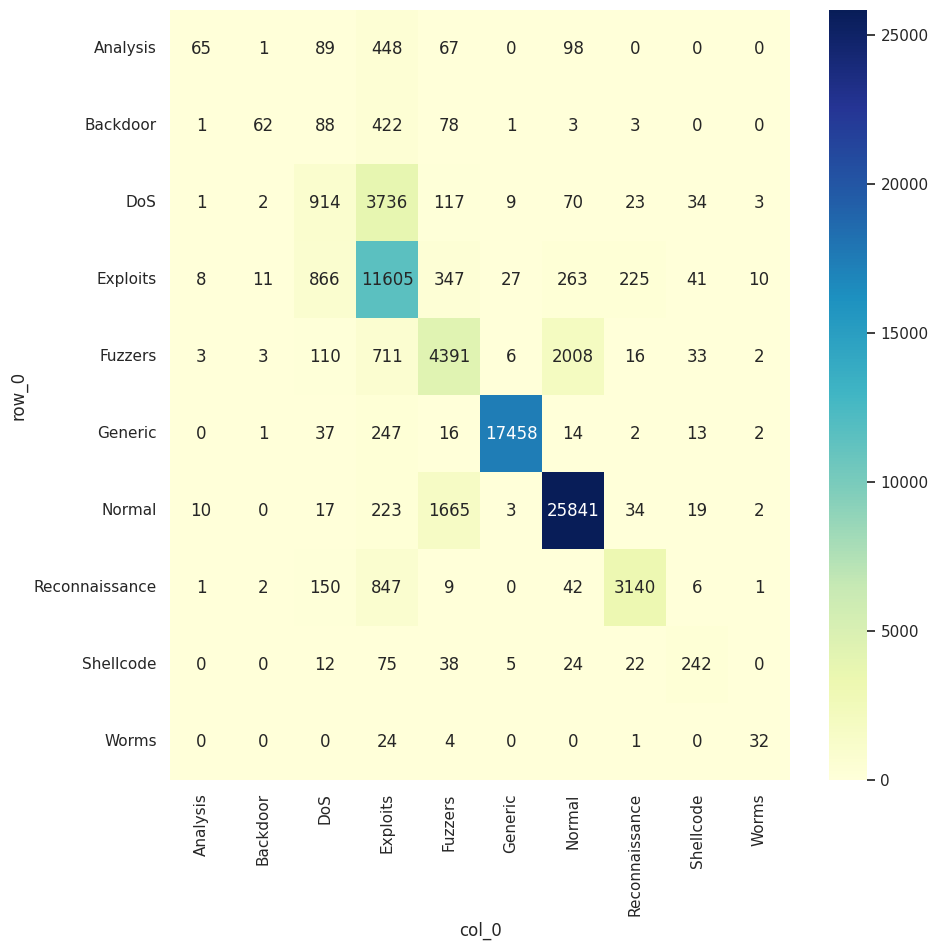

In [42]:
top10= feature_imp.Name[:10].tolist()

X = df.loc[:, df.columns.isin(top10)]

#X = df.loc[:, ~df.columns.isin(['attack_cat', 'label'])]
y = df['attack_cat'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

rf = RandomForestClassifier(random_state=123,min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

cross = pd.crosstab(y_test,  y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cross, annot=True,fmt='d', cmap="YlGnBu")

Network varaibles and their role in detecting different types of cyber attacks.

Deep Neural Network

In [44]:

X = df.select_dtypes(include=[np.number])
y = df['label'].astype('category').cat.codes

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=5)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               22528     
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 96578 (377.26 KB)
Trainable params: 96578 (377.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
6442/6442 [==============================] - 31s 5ms/step - loss: 0.0045 - accuracy: 0.9993
Epoch 2/5
6442/6442 [=========================